<a href="https://colab.research.google.com/github/vicenzocarlim/imeusp/blob/main/Projeto_MAE0552.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Projeto - MAE0552**
## **Classificação de resenhas de filmes**
- Cristine Airi Kimura (13783096);
- Gabriel Medeiros Cupini (13783116);
- João Vítor Guandalini Vicente (15062582);
- Mariana Oliveira Vieira (15647695);
- Olian Castanha Lima (13686261);
- Vicenzo Carlim de Sousa (13686772).



O conjunto de dados que será utilizado é o "IMDb", que pode ser acessado [aqui](https://ai.stanford.edu/~amaas/data/sentiment/). Vamos construir dois modelos de classificação de textos/críticas/resenhas (**análise de sentimentos**), cuja variável resposta é o sentimento em relação ao filme, uma variável binária (**positivo** ou **negativo**).

# **1) Carregar a base de dados**

Primeiramente, precisamos instalar e importar todos os pacotes e módulos do *Python* que serão utilizados nos ajustes dos modelos.

Vamos usar o pacote ```Python torch```, juntamente com o pacote ```pytorch_lightning```, que fornecem ferramentas que simplificam os ajustes e permitem a avaliação do desempenho dos modelos.

Vamos começar instalando, carregando e importando diversas bibliotecas que serão utilizadas na análise.

In [3]:
#Caso seja necessário, descomentar o código abaixo
#para instalar os pacotes
#!pip install ISLP
#!pip install keras
#!pip install torchinfo

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.0 MB/s eta 0:00:00
  

Vamos importar vários módulos da biblioteca ```torch```, que inclum ferramentas relevantes para a construção de redes neurais de estrutura sequencial. O pacote ```torchmetrics``` tem funções que calculam várias métricas para avaliar o desempenho do modelo. Por sua vez, o pacote ```torchinfo``` fornece um resumo de todas as camadas da rede neural ajustada.

O pacote ```pytorch_lightning``` é uma interface de alto nível do pacote ```torch```, que simplifica a especificação e ajuste dos modelos. Além disso, vamos carregar algumas ferramentas do pacote ```ISLP```.

Para carregar a base de dados já pré-processada do "IMDb", vamos utilizar o pacote ```keras```, uma biblioteca de modelos de *deep learning*.

In [1]:
#Importar bibliotecas e módulos
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import \
     (LinearRegression,
      LogisticRegression,
      Lasso)

import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset
from torchmetrics import (MeanAbsoluteError,
                          R2Score)
from torchinfo import summary
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

import pickle
from scipy.sparse import coo_matrix, save_npz

#Carregar a base de dados
from keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

from ISLP.torch.imdb import (load_lookup,
                             load_tensor,
                             load_sparse,
                             load_sequential)
from ISLP.torch import (SimpleDataModule,
                        SimpleModule,
                        ErrorTracker,
                        rec_num_workers)

## 1.1) Tratar a base de dados

Vamos considerar que o tamanho do dicionário são as 10.000 palavras e *tokens* mais frequentes nas resenhas.

A base já está dividida em base de treinamento e de teste. As proporções são de 50% e 50%, ou seja, 25.000 resenhas para cada uma. A variável resposta é o sentimento em relação ao filme, em que **1 = positivo** e **0 = negativo**.

Abaixo, os conjuntos de dados ```imdb_seq_train``` e ```imdb_seq_test``` referem-se aos conjuntos de treinamento e de teste. ```X``` representam as variáveis explicativas, enquanto ```Y```, a variável resposta.

In [8]:
#Separar base de treinamento e de teste
(imdb_seq_train, imdb_seq_test) = load_sequential(root = 'data/IMDB')

Por exemplo, podemos visualizar os atributos da primeira resenha. Cada uma das palavras foram armazenadas na variável ```padded_sample```. No pré-processamento dos dados, as sequências de palavras foram acrescidas de zeros no começo, caso os textos não fossem longos o suficiente.

In [9]:
#Visualizar o exemplo da primeira resenha
padded_sample = np.asarray(imdb_seq_train.tensors[0][0])
sample_review = padded_sample[padded_sample > 0] #remover os zeros
sample_review #1ª resenha

array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468,   66, 3941,    4,  173,   36,  256,    5,   25,  100,   43,
        838,  112,   50,  670,    2,    9,   35,  480,  284,    5,  150,
          4,  172,  112,  167,    2,  336,  385,   39,    4,  172, 4536,
       1111,   17,  546,   38,   13,  447,    4,  192,   50,   16,    6,
        147, 2025,   19,   14,   22,    4, 1920, 4613,  469,    4,   22,
         71,   87,   12,   16,   43,  530,   38,   76,   15,   13, 1247,
          4,   22,   17,  515,   17,   12,   16,  626,   18,    2,    5,
         62,  386,   12,    8,  316,    8,  106,    5,    4, 2223, 5244,
         16,  480,   66, 3785,   33,    4,  130,   12,   16,   38,  619,
          5,   25,  124,   51,   36,  135,   48,   25, 1415,   33,    6,
         22,   12,  215,   28,   77,   52,    5,   14,  407,   16,   82,
          2,    8,    4,  107,  117, 5952,   15,  256,    4,    2,    7,
       3766,    5,  723,   36,   71,   43,  530,  4

Para referenciar cada número (índice) à palavra do dicionário, podemos utilizar a função ```load_lookup``` do módulo ```ISLP.torch.imdb```.

In [10]:
#Decodificar a resenha
lookup = load_lookup(root = 'data/IMDB')
' '.join(lookup[i] for i in sample_review)

Retrieving "IMDB_word_index.pkl" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


"<START> this film was just brilliant casting location scenery story direction everyone's really suited <UNUSED> part they played and you could just imagine being there robert <UNK> is an amazing actor and now <UNUSED> same being director <UNK> father came from <UNUSED> same scottish island as myself so i loved <UNUSED> fact there was a real connection with this film <UNUSED> witty remarks throughout <UNUSED> film were great it was just brilliant so much that i bought <UNUSED> film as soon as it was released for <UNK> and would recommend it to everyone to watch and <UNUSED> fly fishing was amazing really cried at <UNUSED> end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to <UNUSED> two little boy's that played <UNUSED> <UNK> of norman and paul they were just brilliant children are often left out of <UNUSED> <UNK> list i think because <UNUSED> stars that play them all grown up are such a big profile for <UNUSED> 

# **2) Modelo *bag-of-words***

## 2.1) Modelo de redes neurais

Há, no total, 10.000 variáveis explicativas (*features*), que representam cada palavra do dicionário. As *features* são variáveis binárias, que assumem valor 1 se aquela palavra está contida na resenha e 0, caso contrário.

**OBS.:** A maioria das resenhas são curtas, então, a matriz das variáveis explicativas é esparsa (contém uma alta porcentagem de zeros).

Vamos separar a base de treinamento em 80% de treinamento e 20% de validação.

In [11]:
#Acessar as variáveis explicativas
max_num_workers = 10
(imdb_train, imdb_test) = load_tensor(root = 'data/IMDB')

#Separar o conjunto de treinamento em 80% de treinamento e 20% de  validação
imdb_dm = SimpleDataModule(imdb_train, imdb_test, validation = 2000,
                           num_workers = min(6, max_num_workers),
                           batch_size = 512)

Retrieving "IMDB_X_test.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_X_train.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


In [27]:
#Exemplo das primeiras 5 resenhas
imdb_train[0:5]

(tensor([[0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.]]),
 tensor([1., 0., 0., 1., 0.]))

Vamos construir uma **rede neural** com **duas camadas ocultas**.

In [28]:
#Construir uma classe para a rede neural
class IMDBModel(nn.Module):

    #Definir as camadas e as funções de ativação
    def __init__(self, input_size):
        super(IMDBModel, self).__init__()
        self.dense1 = nn.Linear(input_size, 16)
        self.activation = nn.ReLU() #função de ativação ReLU
        self.dense2 = nn.Linear(16, 16) #função de ativação linear
        self.output = nn.Linear(16, 1)

    #Método forward
    def forward(self, x):
        val = x
        for _map in [self.dense1, self.activation, self.dense2, self.activation,
                     self.output]:
            val = _map(val)
        return torch.flatten(val)

Vamos ajustar a rede neural aos dados e observar a saída (resumo).

In [29]:
#Construção da NN
imdb_model = IMDBModel(imdb_test.tensors[0].size()[1])
#Resumo da saída
summary(imdb_model, input_size = imdb_test.tensors[0].size(),
        col_names = ['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
IMDBModel                                [25000, 10003]            [25000]                   --
├─Linear: 1-1                            [25000, 10003]            [25000, 16]               160,064
├─ReLU: 1-2                              [25000, 16]               [25000, 16]               --
├─Linear: 1-3                            [25000, 16]               [25000, 16]               272
├─ReLU: 1-4                              [25000, 16]               [25000, 16]               --
├─Linear: 1-5                            [25000, 16]               [25000, 1]                17
Total params: 160,353
Trainable params: 160,353
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 4.01
Input size (MB): 1000.30
Forward/backward pass size (MB): 6.60
Params size (MB): 0.64
Estimated Total Size (MB): 1007.54

In [30]:
imdb_model

IMDBModel(
  (dense1): Linear(in_features=10003, out_features=16, bias=True)
  (activation): ReLU()
  (dense2): Linear(in_features=16, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)

No ajuste, vamos utilizar uma taxa de aprendizagem menor (η = 0,001). Como as resenhas são classificadas em positivas ou negativas, utilizaremos a função de classificação binária ```SimpleModule.binary_classification()```.

In [31]:
#Determinar taxa de aprendizagem
imdb_optimizer = RMSprop(imdb_model.parameters(), lr = 0.001)
#Otimizar o ajuste
imdb_module = SimpleModule.binary_classification(imdb_model,
                                                 optimizer = imdb_optimizer)

In [37]:
imdb_logger = CSVLogger('logs', name = 'IMDB')
#Ajustar a NN com 30 épocas
imdb_trainer = Trainer(deterministic = True, max_epochs = 30,
                       logger = imdb_logger,
                       callbacks = [ErrorTracker()])
imdb_trainer.fit(imdb_module, datamodule = imdb_dm)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | IMDBModel         | 160 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
160 K     Trainable params
0         Non-trainable params
160 K     Total params
0.641     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (45) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


Por fim, vamos avaliar o desempenho do modelo na base de teste (base inédita), utilizando a acurácia como métrica de *performance*.

In [39]:
#Treinar o modelo na base de teste
test_results = imdb_trainer.test(imdb_module, datamodule = imdb_dm)
test_results

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8519200086593628     │
│         test_loss         │    1.1172404289245605     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.1172404289245605, 'test_accuracy': 0.8519200086593628}]

## 2.2) Regressão logística - LASSO

Vamos ajustar um modelo de regressão logística com regularização do tipo LASSO, utilizando a função ```LogisticRegression()``` do pacote ```sklearn```.

Para tal, vamos precisar utilizar um outro tipo de matriz que é reconhecida pelo ```sklearn```.

In [40]:
#Separar em bases de treino, validação e teste
((X_train, Y_train), (X_valid, Y_valid),
 (X_test, Y_test)) = load_sparse(validation = 2000,
                                 random_state = 0,
                                 root = 'data/IMDB')

Retrieving "IMDB_X_test.npz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_X_train.npz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


Para escolher o melhor valor do parâmetro de regularização do LASSO ($\lambda$), vamos ajustar 50 modelos com $\lambda$s diferentes.

In [41]:
#Testar diferentes valores de lambda
lam_max = np.abs(X_train.T * (Y_train - Y_train.mean())).max()
lam_val = lam_max * np.exp(np.linspace(np.log(1), np.log(1e-4), 50))

Vale notar que, na função ```LogisticRegression()```, o parâmetro de regularização $C$ é o inverso de $\lambda$. O *solver* utilizado será o ```liblinear```, que  costuma funcionar bem com matriz esparsas.

In [44]:
#Ajustar regressão logística LASSO
logit = LogisticRegression(penalty = 'l1',
                           C = 1/lam_max,
                           solver = 'liblinear',
                           warm_start = True,
                           fit_intercept = True)

#Obter os coeficientes do modelo
coefs = [] #coeficientes
intercepts = [] #intercepto

#Obter os coeficientes para cada lambda
for l in lam_val:
    logit.C = 1/l
    logit.fit(X_train, Y_train)
    coefs.append(logit.coef_.copy())
    intercepts.append(logit.intercept_)

In [45]:
#Mostrar os coeficientes estimados
coefs

[array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.]]),
 array([[0.        , 0.01803702, 0.        , ..., 0.     

Como a lista de coeficientes e de interceptos apresenta dimensões a mais do que o necessário, podemos diminuir a dimensão deles.

In [47]:
#Diminuir a dimensão
coefs = np.squeeze(coefs)
intercepts = np.squeeze(intercepts)

coefs #mostrar os coeficientes estimados

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.15740866, 0.05622256, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.2419393 , 0.04848082, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.1837026 , 0.06516726, ..., 0.        , 0.        ,
        0.        ]])

## 2.3) Comparação entre os modelos de redes neurais e LASSO

Vamos fazer um gráfico para comparar a acurácia dos modelos de redes neurais e  LASSO. Antes, precisaremos implementar a função ```summary.plot()```.

In [53]:
#Função que plota a curva de perda no treinamento e na validação
def summary_plot(results, ax, col = 'loss', valid_legend = 'Validation',
                 training_legend = 'Training', ylabel = 'Loss', fontsize = 20):
    for (column, color, label) in zip([f'train_{col}_epoch', f'valid_{col}'],
                       ['black', 'red'], [training_legend, valid_legend]):
        results.plot(x = 'epoch', y = column, label = label, marker = 'o',
                     color = color, ax = ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

In [57]:
#Melhorar a visualização da figura
%%capture
#Definir plano cartesiano
fig, axes = subplots(1, 2, figsize=(16, 8), sharey=True)

#Construir o gráfico
for ((X_, Y_), data_, color) in zip([(X_train, Y_train), (X_valid, Y_valid),
                    (X_test, Y_test)], ['Training', 'Validation', 'Test'],
                    ['black', 'red', 'blue']):
    linpred_ = X_ * coefs.T + intercepts[None,:]
    label_ = np.array(linpred_ > 0)
    accuracy_ = np.array([np.mean(Y_ == l) for l in label_.T])
    axes[0].plot(-np.log(lam_val / X_train.shape[0]), accuracy_, '.--',
                 color = color, markersize = 13, linewidth = 2, label = data_)
#Adicionar as legendas dos eixos
axes[0].legend()
axes[0].set_xlabel(r'$-\log(\lambda)$', fontsize = 20)
axes[0].set_ylabel('Accuracy', fontsize = 20)

#Acessar a acurácia do modelo LASSO
imdb_results = pd.read_csv(imdb_logger.experiment.metrics_file_path)
summary_plot(imdb_results, axes[1], col = 'accuracy', ylabel = 'Accuracy')

#Ajustar os eixos do gráfico
axes[1].set_xticks(np.linspace(0, 30, 7).astype(int))
axes[1].set_ylabel('Accuracy', fontsize=20)
axes[1].set_xlabel('Epoch', fontsize=20)
axes[1].set_ylim([0.5, 1.05]);
axes[1].axhline(test_results[0]['test_accuracy'], color = 'blue',
                linestyle = '--', linewidth = 3)

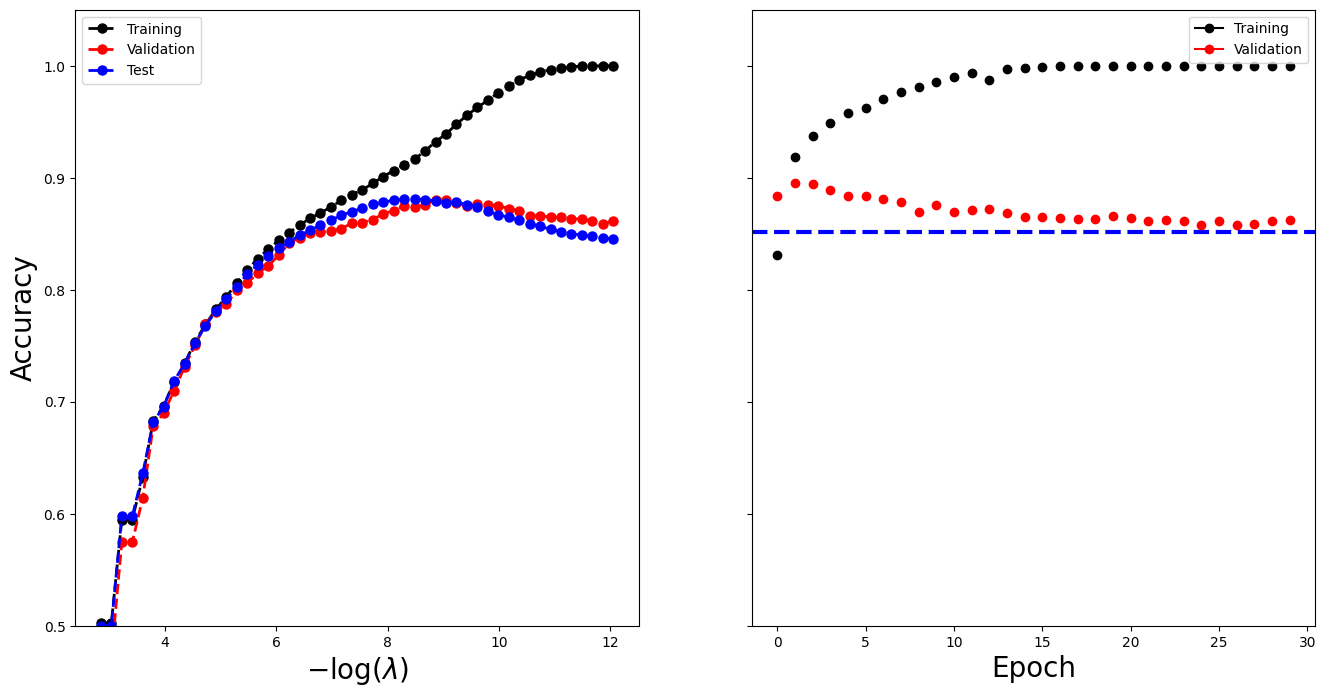

In [58]:
fig #Exibir a figura

Vamos obter o valor da maior acurácia do modelo LASSO.

In [59]:
#Melhor acurácia
lasso_accuracy = max(np.array([np.mean(Y_ == l) for l in label_.T]))
lasso_accuracy

0.88088

Dos gráficos, é possível observar que a acurácia do modelo de regressão logística LASSO é de 0,88, aproximadamente, assim como para a rede neural.

# **3) Modelo sequencial**

## 3.1) Modelo de redes neurais recorrentes (LSTM)

Por fim, vamos ajustar uma rede neural recorrente (LSTM). É necessário utilizar a sequência de palavras do texto, levando em consideração a ordem em que elas aparecem.

Como mais do que 90% das resenhas têm menos do que 500 palavras, vamos limitar o tamanho do texto em 500 palavras. Se houver resenhas maiores, vamos utilizar as últimas 500 palavras e, para textos menores, incluiremos na frente do texto espaços em branco.

In [60]:
#Construir modelo sequencial
imdb_seq_dm = SimpleDataModule(imdb_seq_train, imdb_seq_test,
                               validation = 2000, batch_size = 300,
                               num_workers = min(6, max_num_workers))



*   1ª camada da RNN: *embedding layer*, de tamanho 32. Essa camada codifica cada texto como uma matriz de dimensão 500 $\times$ 10.003 e mapeia essas 10.003 dimensões para 32.
*   2ª camada da RNN: LSTM com 32 unidades;
*   Camada de saída: logit com classificação binária.

Vamos utilizar o método ```forward()``` no ajuste.

In [61]:
#Construir as camadas da RNN
class LSTMModel(nn.Module):

  #Inicializar a RNN
  def __init__(self, input_size):
    super(LSTMModel, self).__init__()
    self.embedding = nn.Embedding(input_size, 32)
    self.lstm = nn.LSTM(input_size = 32, hidden_size = 32, batch_first = True)
    self.dense = nn.Linear(32, 1)

  #Método forward
  def forward(self, x):
    val, (h_n, c_n) = self.lstm(self.embedding(x))
    return torch.flatten(self.dense(val[:,-1]))

Vamos ajustar o modelo RNN e observar a saída (resumo) do modelo, utilizando como exemplo os primeiros 10 textos.

In [62]:
#Ajuste do modelo
lstm_model = LSTMModel(X_test.shape[-1])
#Saída do modelo
summary(lstm_model, input_data = imdb_seq_train.tensors[0][:10],
        col_names = ['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LSTMModel                                [10, 500]                 [10]                      --
├─Embedding: 1-1                         [10, 500]                 [10, 500, 32]             320,096
├─LSTM: 1-2                              [10, 500, 32]             [10, 500, 32]             8,448
├─Linear: 1-3                            [10, 32]                  [10, 1]                   33
Total params: 328,577
Trainable params: 328,577
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 45.44
Input size (MB): 50.00
Forward/backward pass size (MB): 2.56
Params size (MB): 1.31
Estimated Total Size (MB): 53.87

In [63]:
#Ajuste do modelo utilizando o módulo
lstm_module = SimpleModule.binary_classification(lstm_model)
lstm_logger = CSVLogger('logs', name = 'IMDB_LSTM')

#Utilizar 20 épocas no ajuste
lstm_trainer = Trainer(deterministic = True, max_epochs = 20,
                       logger = lstm_logger, callbacks = [ErrorTracker()])
lstm_trainer.fit(lstm_module, datamodule = imdb_seq_dm)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | LSTMModel         | 328 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
328 K     Trainable params
0         Non-trainable params
328 K     Total params
1.314     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Vamos analisar o desempenho do modelo na base de teste, calculando o valor de sua acurácia.

In [64]:
lstm_trainer.test(lstm_module, datamodule = imdb_seq_dm)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8575999736785889     │
│         test_loss         │    0.8279176354408264     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.8279176354408264, 'test_accuracy': 0.8575999736785889}]

A acurácia do modelo é de, aproximadamente, 85,6%.

Vamos construir o gráfico do progresso de aprendizado para esse modelo.

(0.5, 1.0)

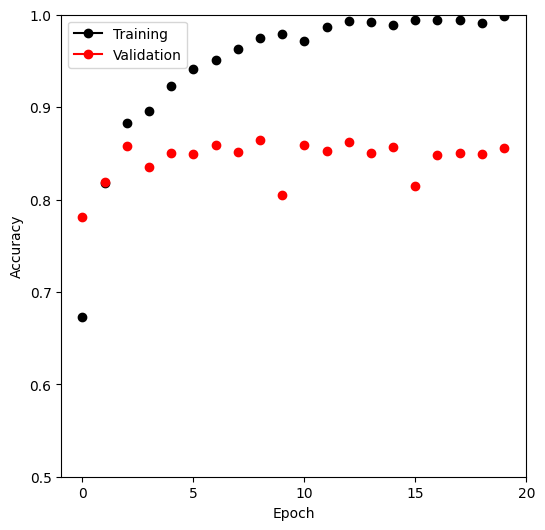

In [65]:
#Construir gráfico da acurácia
lstm_results = pd.read_csv(lstm_logger.experiment.metrics_file_path)
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(lstm_results, ax, col = 'accuracy', ylabel = 'Accuracy')

ax.set_xticks(np.linspace(0, 20, 5).astype(int))
ax.set_ylabel('Accuracy')
ax.set_ylim([0.5, 1])